In [0]:
!unzip images.zip

In [0]:
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
from dataloader import HolonomicDataset
from torch.utils.data import DataLoader
path = './'
dataset = HolonomicDataset('data.csv', path, grayscale=True)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [0]:
class AStarNet(nn.Module):
  def __init__(self):
    super(AStarNet, self).__init__()
    self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
    self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
    self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
    self.conv4 = nn.Conv2d(32, 64, 3, padding=1)
    self.fc1 = nn.Linear(8 * 8 * 64 + 4, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 64)
    self.fc4 = nn.Linear(64, 8)

  def forward(self, x):
    config_states, maps = x
    maps = maps.unsqueeze(1).float().to("cuda")
    config_states = config_states.float().to("cuda")
    x = F.max_pool2d(F.relu(self.conv1(maps)), 2)
    x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    x = F.max_pool2d(F.relu(self.conv3(x)), 2)
    x = F.max_pool2d(F.relu(self.conv4(x)), 2)
    x = x.view(-1, self.num_flat_features(x))
    x = torch.cat((x, config_states), axis=1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x
  
  def num_flat_features(self, x):
    size = x.size()[1:]  # all dimensions except the batch dimension
    num_features = 1
    for s in size:
        num_features *= s
    return num_features

In [0]:
net = AStarNet().to("cuda")
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
JHist = []

In [0]:
# overfit on one batch to make sure everything is working
for i in range(5000):
  optimizer.zero_grad()
  y_pred = net(data)
  loss = criterion(y_pred, label)
  loss.backward()
  optimizer.step()

  epoch_loss = loss.item()
  JHist.append(epoch_loss)
  print(i, epoch_loss)


In [6]:
for j in range(120):
  for i, (input_data, labels) in enumerate(dataloader):

    y_label = labels.to("cuda")
    y_label = y_label - 1
    optimizer.zero_grad()
    y_pred = net(input_data)
    loss = criterion(y_pred, y_label)
    loss.backward()
    optimizer.step()

    epoch_loss = loss.item()
    JHist.append(epoch_loss)
    
    print(i + j * 83, epoch_loss)

Streaming output truncated to the last 5000 lines.
4425 0.3989471197128296
4426 0.45455947518348694
4427 0.41720378398895264
4428 0.4201314449310303
4429 0.43098562955856323
4430 0.38230371475219727
4431 0.3894067406654358
4432 0.5184150338172913
4433 0.4720412790775299
4434 0.43009310960769653
4435 0.4037759304046631
4436 0.4085492789745331
4437 0.37353605031967163
4438 0.427124559879303
4439 0.4135834276676178
4440 0.3788869380950928
4441 0.4012669324874878
4442 0.4211229979991913
4443 0.5060413479804993
4444 0.4381248652935028
4445 0.422304630279541
4446 0.46384239196777344
4447 0.39136239886283875
4448 0.38718700408935547
4449 0.3985959589481354
4450 0.4173153042793274
4451 0.4689856171607971
4452 0.3805522322654724
4453 0.4386630058288574
4454 0.4034128785133362
4455 0.4374259412288666
4456 0.42187246680259705
4457 0.38503897190093994
4458 0.33042100071907043
4459 0.4141179919242859
4460 0.36657628417015076
4461 0.4740253686904907
4462 0.3877418339252472
4463 0.47190648317337036
4

[2.197028875350952, 2.3354032039642334, 2.513160228729248, 2.2867889404296875, 2.078277826309204, 1.9689486026763916, 2.0365614891052246, 2.019360303878784, 1.9945251941680908, 2.0251381397247314, 2.0056405067443848, 1.9832545518875122, 1.9394166469573975, 1.9086651802062988, 1.9628328084945679, 1.8542417287826538, 1.8565117120742798, 1.902758240699768, 1.8431084156036377, 1.7873867750167847, 1.8059602975845337, 1.6183711290359497, 1.7067620754241943, 1.702122688293457, 1.5012125968933105, 1.47923743724823, 1.5980150699615479, 1.4126628637313843, 1.421047329902649, 1.374354362487793, 1.328930377960205, 1.328127384185791, 1.229624629020691, 1.2347723245620728, 1.181563377380371, 1.1564353704452515, 1.1764650344848633, 1.0790519714355469, 1.190354347229004, 1.2409402132034302, 1.2694077491760254, 1.0761085748672485, 1.1030112504959106, 1.1269257068634033, 1.0693062543869019, 0.8912177681922913, 0.8820989727973938, 1.0886856317520142, 0.9943452477455139, 1.0208202600479126, 0.920014321804

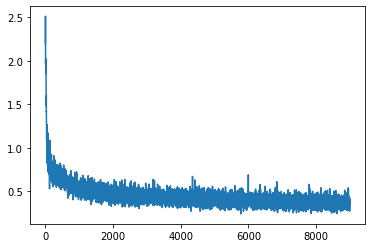

In [7]:
import matplotlib.pyplot as plt
print(JHist)
plt.plot(JHist)

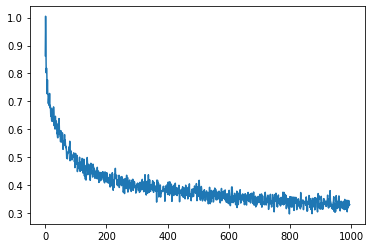

In [8]:
JHist_avg = []
sum = 0
for index in range(30, len(JHist)):
  sum += JHist[index]
  if index % 9 == 0:
    JHist_avg.append(sum / 10)
    sum = 0

plt.plot(JHist_avg)

In [9]:
# check labels on one batch
test_input, test_label = None, None
for i, (input_data, labels) in enumerate(dataloader):
  test_input = input_data
  test_label = labels.to("cuda")
  break

y_pred = net(test_input)
print(y_pred.shape)
pred_actions = torch.argmax(y_pred, axis=1)
print(pred_actions)
print(test_label - 1)

correct = 0
for i in range(128):
  if pred_actions[i] == test_label[i] - 1:
    correct += 1
print(correct / 128)

torch.Size([128, 8])
tensor([7, 4, 0, 0, 0, 6, 3, 4, 1, 4, 3, 0, 3, 7, 7, 5, 7, 3, 6, 5, 1, 0, 4, 0,
        7, 4, 1, 3, 3, 7, 1, 2, 5, 6, 5, 5, 0, 3, 3, 7, 1, 5, 0, 6, 4, 4, 4, 1,
        2, 3, 5, 3, 4, 4, 1, 6, 4, 1, 6, 7, 2, 3, 3, 2, 0, 1, 6, 4, 3, 5, 2, 6,
        1, 5, 3, 1, 2, 3, 4, 6, 3, 5, 3, 5, 1, 3, 3, 3, 6, 5, 3, 4, 6, 4, 6, 6,
        4, 5, 4, 6, 5, 7, 5, 0, 2, 6, 1, 5, 6, 1, 7, 3, 7, 3, 3, 6, 6, 4, 1, 0,
        6, 1, 2, 6, 0, 5, 4, 2], device='cuda:0', grad_fn=<NotImplemented>)
tensor([7, 4, 0, 0, 0, 6, 3, 4, 1, 4, 5, 0, 3, 7, 7, 5, 7, 3, 7, 6, 1, 0, 7, 0,
        7, 4, 1, 3, 0, 7, 1, 2, 5, 5, 5, 3, 0, 3, 3, 7, 1, 5, 0, 6, 4, 4, 2, 0,
        4, 5, 6, 3, 4, 4, 1, 7, 4, 1, 7, 7, 2, 3, 5, 2, 0, 1, 6, 4, 3, 5, 2, 6,
        1, 5, 3, 1, 2, 3, 4, 6, 0, 5, 3, 6, 1, 3, 5, 5, 6, 5, 3, 4, 7, 4, 6, 6,
        4, 3, 4, 6, 5, 7, 5, 0, 1, 6, 2, 6, 6, 1, 7, 5, 7, 5, 3, 7, 6, 4, 1, 0,
        7, 0, 2, 6, 0, 5, 4, 2], device='cuda:0')
0.7734375


In [0]:
from google.colab import files
PATH = './AStarNet.pth'
torch.save(net.state_dict(), PATH)
files.download(PATH)